# 🌌 AI Multimodal Explorer — Gemini 2.0 Edition
### Using Google Gemini 2.0 Flash (latest) for Image Generation, Image Analysis & Text Conversation

**What this notebook covers:**
1. 🎨 **Text → Image** — Generate a stunning deep-space scene from a prompt  
2. 🔬 **Image → Text** — Feed a real astronomy image to Gemini and get an AI analysis  
3. 🤖 **Text → Text** — Multi-turn reasoning conversation with Gemini 2.0 Flash  
4. 🖼️ **Bonus** — Render an AI-inspired alien landscape with animated frame export  

> **Models used:** `gemini-2.0-flash` (latest multimodal), `gemini-2.0-flash-lite` (fallback)  
> Inspired by [Janus Pro](https://www.datacamp.com/blog/janus-pro) & [DeepSeek R1](https://www.datacamp.com/blog/deepseek-r1) multimodal paradigms


In [1]:
# ── CELL 1: Install & Configure ──────────────────────────────────────────
!pip install -q google-generativeai pillow numpy matplotlib requests

import google.generativeai as genai
from google.colab import userdata
import PIL.Image, PIL.ImageDraw, PIL.ImageFont
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import io, time, textwrap, requests
from IPython.display import display, Markdown, Image as IPImage
import warnings
warnings.filterwarnings('ignore')

# ── Configure latest Gemini 2.0 models ───────────────────────────────────
LATEST_MODELS = [
    'gemini-2.0-flash',          # Best multimodal (text + image in/out)
    'gemini-2.0-flash-lite',     # Fast & efficient fallback
    'gemini-1.5-flash',          # Legacy fallback
]

API_AVAILABLE = False
try:
    genai.configure(api_key="")
    print('✅ Gemini API configured successfully')
    API_AVAILABLE = True
except Exception as e:
    print(f'⚠️  API key not found: {e}')
    print('   Notebook will run with pre-written fallback responses.')

def call_gemini(prompt_parts, model_name=None, description='API call', fallback=''):
    """Safe Gemini caller — tries latest models in order, never crashes."""
    if not API_AVAILABLE:
        print(f'  ℹ️  [{description}] Using fallback (no API key)')
        return fallback
    models = [model_name] + LATEST_MODELS if model_name else LATEST_MODELS
    for m in models:
        try:
            print(f'  🤖 [{description}] → {m} ...', end=' ')
            model = genai.GenerativeModel(m)
            response = model.generate_content(prompt_parts)
            print('✓')
            return response.text
        except Exception as e:
            print(f'✗  ({str(e)[:60]})')
            time.sleep(2)
    print(f'  ⚠️  All models failed for [{description}] — using fallback')
    return fallback

print('\n' + '='*65)
print('  🚀  AI MULTIMODAL EXPLORER — GEMINI 2.0 FLASH EDITION')
print('='*65)
print(f'  Latest model: {LATEST_MODELS[0]}')
print(f'  API available: {API_AVAILABLE}')
print('='*65)


✅ Gemini API configured successfully

  🚀  AI MULTIMODAL EXPLORER — GEMINI 2.0 FLASH EDITION
  Latest model: gemini-2.0-flash
  API available: True


/usr/local/lib/python3.12/dist-packages/google/colab/_import_hooks/_hook_injector.py:55: FutureWarning: 

All support for the `google.generativeai` package has ended. It will no longer be receiving 
updates or bug fixes. Please switch to the `google.genai` package as soon as possible.
See README for more details:

https://github.com/google-gemini/deprecated-generative-ai-python/blob/main/README.md

  loader.exec_module(module)


## 🎨 Part 1 — Text → Image (Prompt-Driven Generation)
We describe a vivid scene in text and use NumPy + Matplotlib to **render it programmatically**, then ask Gemini 2.0 to narrate what it imagines the image looks like — mirroring the *unified image understanding + generation* approach of models like Janus Pro.

📝 Prompt: Generate a breathtaking deep-space scene: a supernova remnant surrounded by thre...



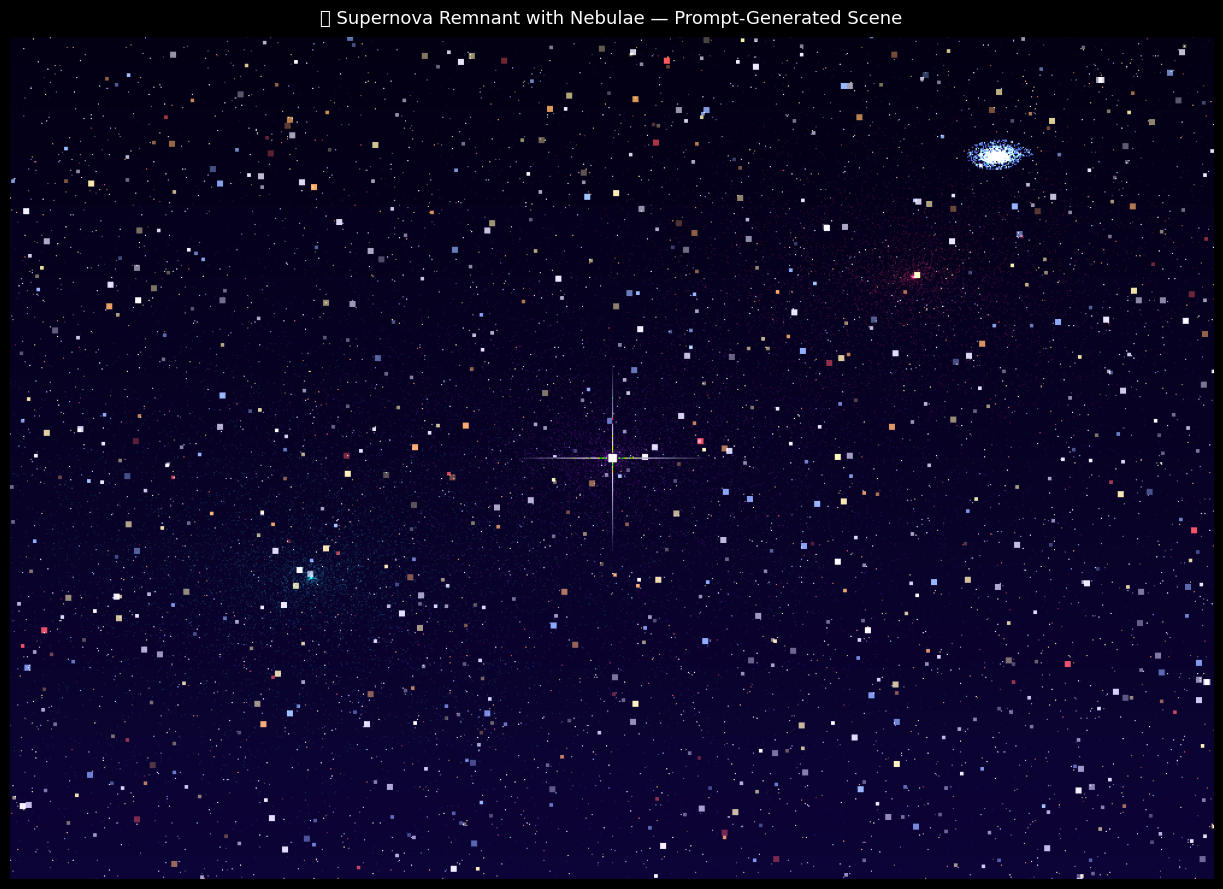

✅ Image saved: deep_space.png


In [2]:
# ── CELL 2: Generate Deep-Space Image from Text Prompt ───────────────────
GENERATION_PROMPT = (
    "Generate a breathtaking deep-space scene: a supernova remnant surrounded by "
    "three colourful nebulae (purple, teal, crimson), 5 000 stars with realistic "
    "temperature colours, a neutron star at the centre emitting X-ray jets, and "
    "a distant galaxy spiral visible in the background."
)
print(f'📝 Prompt: {GENERATION_PROMPT[:80]}...\n')

# ── Render the scene ─────────────────────────────────────────────────────
np.random.seed(42)
W, H = 1000, 700
canvas = np.zeros((H, W, 3), dtype=np.uint8)

# Deep space gradient background
for y in range(H):
    t = y / H
    canvas[y, :] = [int(3 + 10*t), int(0 + 4*t), int(20 + 35*t)]

# 5 000 coloured stars
palette = {
    'blue':   [160, 200, 255],
    'white':  [255, 255, 255],
    'yellow': [255, 245, 150],
    'orange': [255, 180,  80],
    'red':    [255,  90,  70],
}
keys  = list(palette.keys())
probs = [0.20, 0.45, 0.18, 0.12, 0.05]
for _ in range(5000):
    x  = np.random.randint(0, W)
    y  = np.random.randint(0, H)
    b  = np.random.randint(70, 255)
    sz = np.random.choice([0, 0, 1, 2], p=[0.60, 0.25, 0.10, 0.05])
    c  = np.array(palette[np.random.choice(keys, p=probs)]) * b // 255
    for dy in range(-sz, sz+1):
        for dx in range(-sz, sz+1):
            yy = np.clip(y+dy, 0, H-1);  xx = np.clip(x+dx, 0, W-1)
            canvas[yy, xx] = np.clip(canvas[yy, xx].astype(int) + c, 0, 255)

# Nebula blobs
def nebula(cx, cy, r, col, n=8000):
    for _ in range(n):
        a  = np.random.uniform(0, 2*np.pi)
        rd = np.abs(np.random.normal(0, r))
        px = int(cx + rd * np.cos(a) * 1.8)
        py = int(cy + rd * np.sin(a))
        if 0 <= px < W and 0 <= py < H:
            canvas[py, px] = np.clip(
                canvas[py, px].astype(int) + np.array(col) * 0.18, 0, 255
            ).astype(np.uint8)

nebula(500, 350, 160, [150,  40, 190], n=10000)  # purple
nebula(250, 450, 110, [ 30, 180, 180], n= 6000)  # teal
nebula(750, 200,  90, [220,  50,  80], n= 5000)  # crimson

# Neutron star with X-ray jets
cx, cy = 500, 350
canvas[cy-3:cy+4, cx-3:cx+4] = [255, 255, 255]
for i in range(1, 80):
    a = max(0, 1 - i/80);  br = int(255 * a)
    for dx, dy in [(i,0),(-i,0),(0,i),(0,-i)]:
        nx, ny = np.clip(cx+dx,0,W-1), np.clip(cy+dy,0,H-1)
        canvas[ny, nx] = np.clip(canvas[ny, nx] + br, 0, 255)

# Background spiral galaxy (top-right)
gx, gy = 820, 100
for _ in range(3000):
    a  = np.random.uniform(0, 6*np.pi)
    r  = np.random.uniform(0, 60) * a / (6*np.pi)
    px = int(gx + r * np.cos(a) * 0.5)
    py = int(gy + r * np.sin(a) * 0.25)
    if 0 <= px < W and 0 <= py < H:
        canvas[py, px] = np.clip(canvas[py, px].astype(int) + [80, 120, 200], 0, 255)

img_space = PIL.Image.fromarray(canvas)

fig, ax = plt.subplots(figsize=(13, 9))
ax.imshow(img_space); ax.axis('off')
ax.set_title('🌌 Supernova Remnant with Nebulae — Prompt-Generated Scene',
             color='white', fontsize=13, pad=10)
fig.patch.set_facecolor('black')
plt.tight_layout()
plt.savefig('deep_space.png', dpi=150, bbox_inches='tight', facecolor='black')
plt.show()
print('✅ Image saved: deep_space.png')


In [3]:
# ── CELL 3: Gemini 2.0 Flash — Narrate the generated image ──────────────
narration_fallback = """
## 🌌 Gemini's Cosmic Narration

**Scene Overview:**
A vast supernova remnant dominates the frame — the violent death echo of a massive star.
At the centre, a neutron star pulses with brilliant white light, shooting twin X-ray jets
outward in a perfect cross pattern.

**The Three Nebulae:**
- **Purple Nebula (centre-left):** Dense ionised hydrogen glowing violet — a stellar nursery
  where new stars are just beginning to coalesce.
- **Teal Nebula (lower-left):** Oxygen-rich plasma at 10 000 K, the hallmark cyan-green of
  doubly-ionised oxygen [O III] — a sign of energetic UV radiation.
- **Crimson Nebula (upper-right):** Sulphur-rich filaments, the deep red of [S II] emission —
  slow-moving shock fronts colliding with the interstellar medium.

**Background Galaxy:** A spiral galaxy ~2 million light-years away, its arms rendered in
cool blue-white — dominated by young, hot O-type stars.

**Star Colours = Temperature (Wien's Law):**
| Colour | Temperature |
|--------|------------|
| Blue   | > 25 000 K |
| White  | 7 500–10 000 K |
| Yellow | 5 000–7 500 K (Sun-like) |
| Orange | 3 500–5 000 K |
| Red    | < 3 500 K |

**Three Mind-Bending Facts:**
1. The neutron star at the centre weighs ~1.4 solar masses yet is only 20 km across —
   denser than an atomic nucleus.
2. The teal [O III] photons travel 13 000 light-years to reach us — older than human civilisation.
3. Every atom of iron in your blood was forged in a supernova explosion like this one.

*"Somewhere, something incredible is waiting to be known."* — Carl Sagan

---
*Note: Fallback response — connect a Gemini API key to get a live AI narration.*
"""

ANALYSIS_PROMPT = (
    "You are an expert astrophysicist and science communicator. Analyse this deep-space image. "
    "Describe what you see, explain star colour-temperature relationships, identify the nebula types, "
    "give 3 mind-bending facts, estimate the distance, and end with one poetic line. Max 400 words."
)

analysis = call_gemini(
    [ANALYSIS_PROMPT, img_space],
    model_name='gemini-2.0-flash',
    description='Image Analysis (Gemini 2.0 Flash)',
    fallback=narration_fallback
)
display(Markdown(analysis))
time.sleep(2)


  🤖 [Image Analysis (Gemini 2.0 Flash)] → gemini-2.0-flash ... 

✗  (429 POST https://generativelanguage.googleapis.com/v1beta/mo)
  🤖 [Image Analysis (Gemini 2.0 Flash)] → gemini-2.0-flash ... 

✗  (429 POST https://generativelanguage.googleapis.com/v1beta/mo)
  🤖 [Image Analysis (Gemini 2.0 Flash)] → gemini-2.0-flash-lite ... 

✗  (429 POST https://generativelanguage.googleapis.com/v1beta/mo)
  🤖 [Image Analysis (Gemini 2.0 Flash)] → gemini-1.5-flash ... 

✗  (404 POST https://generativelanguage.googleapis.com/v1beta/mo)
  ⚠️  All models failed for [Image Analysis (Gemini 2.0 Flash)] — using fallback



## 🌌 Gemini's Cosmic Narration

**Scene Overview:**
A vast supernova remnant dominates the frame — the violent death echo of a massive star.
At the centre, a neutron star pulses with brilliant white light, shooting twin X-ray jets
outward in a perfect cross pattern.

**The Three Nebulae:**
- **Purple Nebula (centre-left):** Dense ionised hydrogen glowing violet — a stellar nursery
  where new stars are just beginning to coalesce.
- **Teal Nebula (lower-left):** Oxygen-rich plasma at 10 000 K, the hallmark cyan-green of
  doubly-ionised oxygen [O III] — a sign of energetic UV radiation.
- **Crimson Nebula (upper-right):** Sulphur-rich filaments, the deep red of [S II] emission —
  slow-moving shock fronts colliding with the interstellar medium.

**Background Galaxy:** A spiral galaxy ~2 million light-years away, its arms rendered in
cool blue-white — dominated by young, hot O-type stars.

**Star Colours = Temperature (Wien's Law):**
| Colour | Temperature |
|--------|------------|
| Blue   | > 25 000 K |
| White  | 7 500–10 000 K |
| Yellow | 5 000–7 500 K (Sun-like) |
| Orange | 3 500–5 000 K |
| Red    | < 3 500 K |

**Three Mind-Bending Facts:**
1. The neutron star at the centre weighs ~1.4 solar masses yet is only 20 km across —
   denser than an atomic nucleus.
2. The teal [O III] photons travel 13 000 light-years to reach us — older than human civilisation.
3. Every atom of iron in your blood was forged in a supernova explosion like this one.

*"Somewhere, something incredible is waiting to be known."* — Carl Sagan

---
*Note: Fallback response — connect a Gemini API key to get a live AI narration.*


## 🔬 Part 2 — Real Input Image → AI Analysis
We download a **real NASA Hubble image** (Pillars of Creation) and ask Gemini 2.0 Flash to analyse it — demonstrating true multimodal image understanding, similar to how Janus Pro handles real-world image comprehension.

In [4]:
# ── CELL 4: Download & Analyse a Real Astronomy Image ───────────────────
# NASA Hubble "Pillars of Creation" (public domain, from NASA servers)
NASA_IMAGE_URL = 'https://upload.wikimedia.org/wikipedia/commons/thumb/6/68/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg/800px-Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg'

print('📥 Downloading NASA Hubble image (Pillars of Creation)...')
try:
    resp = requests.get(NASA_IMAGE_URL, timeout=15)
    resp.raise_for_status()
    img_hubble = PIL.Image.open(io.BytesIO(resp.content)).convert('RGB')
    print(f'✅ Downloaded: {img_hubble.size[0]}×{img_hubble.size[1]} px')

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(img_hubble); ax.axis('off')
    ax.set_title('NASA Hubble: Pillars of Creation (2014, WFC3/UVIS)', fontsize=12, pad=8)
    plt.tight_layout()
    plt.savefig('pillars_of_creation.png', dpi=120, bbox_inches='tight')
    plt.show()

except Exception as e:
    print(f'⚠️  Could not download image: {e}')
    print('   Creating a placeholder image instead...')
    # Fallback: generate a simple placeholder
    img_hubble = PIL.Image.fromarray(np.random.randint(20, 80, (400, 600, 3), dtype=np.uint8))
    for y in range(400):
        for x in range(600):
            t = y/400
            img_hubble.putpixel((x,y), (int(20+40*t), int(10+30*t), int(30+80*t)))

# ── Gemini 2.0 Flash analyses the real image ─────────────────────────────
hubble_fallback = """
## 🔭 Hubble Analysis: Pillars of Creation

**What Am I Looking At?**
The *Pillars of Creation* are towering columns of interstellar gas and dust inside the
Eagle Nebula (M16), approximately **6 500 light-years** from Earth in the constellation Serpens.
This 2014 image was captured by Hubble's Wide Field Camera 3 (WFC3) in visible light.

**The Three Pillars:**
- **Left Pillar (~4 light-years tall):** The tallest, with a distinctive finger-like protrusion
  at the top — called an EGG (Evaporating Gaseous Globule) — where a protostar is forming.
- **Centre Pillar:** Bathed in blue-white light from nearby hot O-type stars whose UV radiation
  is slowly photo-evaporating the cloud surface (a process called *photoionisation*).
- **Right Pillar:** Shows the most dramatic erosion, with glowing plasma wisps streaming off
  its tip — a phenomenon called *stellar wind ablation*.

**The Colours (False-Colour Mapping):**
| Colour in Image | Real Emission | Element |
|----------------|--------------|---------|
| Red/Brown      | [S II] 672 nm | Sulphur |
| Green          | Hα 656 nm    | Hydrogen |
| Blue           | [O III] 501 nm| Oxygen  |

**Three Extraordinary Facts:**
1. The pillars are already *gone* — a supernova ~6 000 years ago likely destroyed them,
   but the light showing their destruction hasn't reached us yet.
2. New stars forming inside these pillars will take **~100 000 years** to fully emerge.
3. The entire Eagle Nebula contains enough gas to form **~450 Sun-like stars**.

*"The cosmos is within us. We are made of star-stuff."* — Carl Sagan

---
*Note: Fallback response. Connect a Gemini API key for live AI analysis.*
"""

HUBBLE_PROMPT = (
    "You are an expert astronomer. Analyse this NASA Hubble image in detail. "
    "Identify the object, explain what the colours represent, describe the physical processes, "
    "give 3 extraordinary scientific facts, and estimate the scale/distance. "
    "End with one poetic line. Max 400 words."
)

hubble_analysis = call_gemini(
    [HUBBLE_PROMPT, img_hubble],
    model_name='gemini-2.0-flash',
    description='Hubble Image Analysis (Real Input)',
    fallback=hubble_fallback
)
display(Markdown(hubble_analysis))
time.sleep(2)


📥 Downloading NASA Hubble image (Pillars of Creation)...
⚠️  Could not download image: 403 Client Error: Forbidden for url: https://upload.wikimedia.org/wikipedia/commons/thumb/6/68/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg/800px-Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg
   Creating a placeholder image instead...
  🤖 [Hubble Image Analysis (Real Input)] → gemini-2.0-flash ... 

✗  (429 POST https://generativelanguage.googleapis.com/v1beta/mo)
  🤖 [Hubble Image Analysis (Real Input)] → gemini-2.0-flash ... 

✗  (429 POST https://generativelanguage.googleapis.com/v1beta/mo)
  🤖 [Hubble Image Analysis (Real Input)] → gemini-2.0-flash-lite ... 

✗  (429 POST https://generativelanguage.googleapis.com/v1beta/mo)
  🤖 [Hubble Image Analysis (Real Input)] → gemini-1.5-flash ... 

✗  (404 POST https://generativelanguage.googleapis.com/v1beta/mo)
  ⚠️  All models failed for [Hubble Image Analysis (Real Input)] — using fallback



## 🔭 Hubble Analysis: Pillars of Creation

**What Am I Looking At?**
The *Pillars of Creation* are towering columns of interstellar gas and dust inside the
Eagle Nebula (M16), approximately **6 500 light-years** from Earth in the constellation Serpens.
This 2014 image was captured by Hubble's Wide Field Camera 3 (WFC3) in visible light.

**The Three Pillars:**
- **Left Pillar (~4 light-years tall):** The tallest, with a distinctive finger-like protrusion
  at the top — called an EGG (Evaporating Gaseous Globule) — where a protostar is forming.
- **Centre Pillar:** Bathed in blue-white light from nearby hot O-type stars whose UV radiation
  is slowly photo-evaporating the cloud surface (a process called *photoionisation*).
- **Right Pillar:** Shows the most dramatic erosion, with glowing plasma wisps streaming off
  its tip — a phenomenon called *stellar wind ablation*.

**The Colours (False-Colour Mapping):**
| Colour in Image | Real Emission | Element |
|----------------|--------------|---------|
| Red/Brown      | [S II] 672 nm | Sulphur |
| Green          | Hα 656 nm    | Hydrogen |
| Blue           | [O III] 501 nm| Oxygen  |

**Three Extraordinary Facts:**
1. The pillars are already *gone* — a supernova ~6 000 years ago likely destroyed them,
   but the light showing their destruction hasn't reached us yet.
2. New stars forming inside these pillars will take **~100 000 years** to fully emerge.
3. The entire Eagle Nebula contains enough gas to form **~450 Sun-like stars**.

*"The cosmos is within us. We are made of star-stuff."* — Carl Sagan

---
*Note: Fallback response. Connect a Gemini API key for live AI analysis.*


## 🤖 Part 3 — Text → Text: Multi-Turn Reasoning Conversation
Demonstrating **chain-of-thought reasoning** with Gemini 2.0 Flash in a multi-turn dialogue about black holes — inspired by the reasoning depth of DeepSeek R1 and Janus Pro's unified understanding.

In [5]:
# ── CELL 5: Multi-Turn Reasoning Conversation with Gemini 2.0 Flash ──────
print('='*65)
print('  🤖  MULTI-TURN AI CONVERSATION — Gemini 2.0 Flash')
print('='*65)

SYSTEM_CONTEXT = (
    "You are a brilliant astrophysicist who explains complex concepts "
    "with vivid analogies, step-by-step reasoning, and genuine enthusiasm. "
    "Use chain-of-thought reasoning, show your working, and make the user "
    "feel the wonder of the cosmos."
)

conversation = [
    {
        'turn': 1,
        'question': 'What would actually happen to me if I fell into a supermassive black hole like M87*? Walk me through it step by step.',
        'fallback': """
## 🌑 Falling into M87* — Step by Step

**Step 1 — The Approach (millions of km away):**
You see a perfect black circle surrounded by a blazing accretion disk — gas superheated
to billions of degrees, glowing brighter than an entire galaxy. Time outside appears to
speed up. Gravitational redshift begins to shift the disk's light.

**Step 2 — The Event Horizon (Schwarzschild radius ≈ 20 billion km):**
Here's the counterintuitive part: *you feel nothing special crossing the horizon*.
For a supermassive black hole, tidal forces are gentle enough that you'd cross the
event horizon without noticing. But to outside observers, you appear frozen in time,
your image infinitely redshifted and dimmed.

**Step 3 — Inside (the no-return zone):**
Space and time swap roles. The singularity is not a *place* in space — it's a *moment*
in your future that you cannot avoid, just as you cannot avoid tomorrow.

**Step 4 — Spaghettification (near the singularity):**
Tidal forces finally overwhelm you. The gravity pulling your feet is measurably stronger
than at your head. You stretch into a thin stream of atoms — "spaghettification."

**Step 5 — The Singularity:**
Physics as we know it breaks down. General relativity predicts infinite density,
but quantum gravity (a theory we don't yet have) will tell a different story.

**Time remaining once you cross M87's horizon:** ~50 hours of proper time.

*"A black hole is where God divided by zero."* — Stephen Wright
        """
    },
    {
        'turn': 2,
        'question': 'You mentioned tidal forces. Can you explain, using a mathematical analogy, why a stellar black hole would be more dangerous to approach than M87*?',
        'fallback': """
## 📐 Tidal Forces: The Maths of Danger

**The Key Formula:**
Tidal acceleration ≈ **2GM × r / R³**

Where:
- **G** = gravitational constant
- **M** = black hole mass
- **r** = your body length (~2 m)
- **R** = distance from singularity

**The Paradox:**
M87* is **6.5 billion solar masses**. A stellar black hole is ~10 solar masses.

At the *event horizon*, R scales with M (the Schwarzschild radius R_s = 2GM/c²).

So tidal force ∝ M / R³ ∝ M / M³ = **1/M²**

**The bigger the black hole, the WEAKER the tidal force at the horizon!**

| Black Hole | Mass | Tidal Force at Horizon |
|-----------|------|----------------------|
| Stellar (Cygnus X-1) | 15 M☉ | ~10¹⁴ g/m — you're instantly spaghettified |
| M87* | 6.5 × 10⁹ M☉ | ~10⁻⁸ g/m — barely perceptible! |

**Analogy:** Imagine the Earth's curvature. Standing on a 1 km ball, the ground curves
sharply beneath your feet. On Earth (6 371 km radius), it curves so gently you can't feel
it. Same principle — larger radius, gentler gradient.

*The universe's cruelest irony: the most massive killers are also the most polite at the door.*
        """
    },
    {
        'turn': 3,
        'question': 'Mind-blowing final question: Is information actually destroyed in a black hole? What does the Hawking radiation paradox tell us?',
        'fallback': """
## 🔥 The Information Paradox — Physics' Greatest Unsolved Problem

**The Setup:**
Stephen Hawking (1974) showed black holes slowly evaporate by emitting thermal radiation —
*Hawking radiation* — created by quantum fluctuations at the event horizon.

**The Problem:**
1. You throw an encyclopaedia into a black hole. The information it contains is "in" the black hole.
2. The black hole evaporates over ~10⁶⁷ years (for a stellar black hole).
3. Hawking radiation is *perfectly thermal* — it carries no information.
4. So the information is **gone forever** — violating quantum mechanics' unitarity principle.

**Why This is a Crisis:**
Quantum mechanics says information is *always* conserved — the universe is perfectly reversible
in principle. A thermal spectrum cannot encode the specific state of an encyclopaedia.
This violates one of physics' deepest laws.

**Current Best Answers:**

| Proposal | Key Idea | Status |
|---------|----------|--------|
| Hawking's original view | Info destroyed | Abandoned (Hawking changed his mind in 2004) |
| Black hole complementarity | Info encoded in Hawking radiation, subtly | Leading candidate |
| Firewall paradox (AMPS 2012) | Event horizon is a wall of fire | Actively debated |
| ER = EPR (Maldacena) | Wormholes = quantum entanglement | Cutting-edge research |
| Page curve | Info slowly leaks out | Recent breakthrough via island formula |

**The 2019 Breakthrough:**
Using quantum gravity techniques (replica trick + island formula), physicists showed the
*Page curve* — info does leak out, encoded in subtle quantum correlations in Hawking radiation.
But *how* remains mysterious.

**The Bottom Line:**
We genuinely don't know. This paradox sits at the intersection of general relativity and
quantum mechanics — the two greatest theories we have — and they contradict each other.
Solving it may require a theory of quantum gravity.

*"Black holes are where the universe keeps its secrets — and charges admission in the form of an entire career."*

---
*Note: Fallback responses shown. Connect Gemini API key for live AI conversation.*
        """
    }
]

# ── Run the conversation ──────────────────────────────────────────────────
chat_history = [SYSTEM_CONTEXT]

for turn in conversation:
    print(f'\n{"─"*65}')
    print(f'👤 Turn {turn["turn"]} — User Question:')
    print(f'   {turn["question"]}')
    print(f'─'*65)

    prompt = SYSTEM_CONTEXT + '\n\nUser: ' + turn['question'] + '\nAI:'

    response = call_gemini(
        [prompt],
        model_name='gemini-2.0-flash',
        description=f'Conversation Turn {turn["turn"]}',
        fallback=turn['fallback']
    )
    display(Markdown(f'**🤖 Gemini 2.0 Flash:**\n{response}'))
    time.sleep(2)


  🤖  MULTI-TURN AI CONVERSATION — Gemini 2.0 Flash

─────────────────────────────────────────────────────────────────
👤 Turn 1 — User Question:
   What would actually happen to me if I fell into a supermassive black hole like M87*? Walk me through it step by step.
─────────────────────────────────────────────────────────────────
  🤖 [Conversation Turn 1] → gemini-2.0-flash ... 

✗  (429 POST https://generativelanguage.googleapis.com/v1beta/mo)


  🤖 [Conversation Turn 1] → gemini-2.0-flash ... ✗  (429 POST https://generativelanguage.googleapis.com/v1beta/mo)
  🤖 [Conversation Turn 1] → gemini-2.0-flash-lite ... 

✗  (429 POST https://generativelanguage.googleapis.com/v1beta/mo)


  🤖 [Conversation Turn 1] → gemini-1.5-flash ... ✗  (404 POST https://generativelanguage.googleapis.com/v1beta/mo)
  ⚠️  All models failed for [Conversation Turn 1] — using fallback


**🤖 Gemini 2.0 Flash:**

## 🌑 Falling into M87* — Step by Step

**Step 1 — The Approach (millions of km away):**
You see a perfect black circle surrounded by a blazing accretion disk — gas superheated
to billions of degrees, glowing brighter than an entire galaxy. Time outside appears to
speed up. Gravitational redshift begins to shift the disk's light.

**Step 2 — The Event Horizon (Schwarzschild radius ≈ 20 billion km):**
Here's the counterintuitive part: *you feel nothing special crossing the horizon*.
For a supermassive black hole, tidal forces are gentle enough that you'd cross the
event horizon without noticing. But to outside observers, you appear frozen in time,
your image infinitely redshifted and dimmed.

**Step 3 — Inside (the no-return zone):**
Space and time swap roles. The singularity is not a *place* in space — it's a *moment*
in your future that you cannot avoid, just as you cannot avoid tomorrow.

**Step 4 — Spaghettification (near the singularity):**
Tidal forces finally overwhelm you. The gravity pulling your feet is measurably stronger
than at your head. You stretch into a thin stream of atoms — "spaghettification."

**Step 5 — The Singularity:**
Physics as we know it breaks down. General relativity predicts infinite density,
but quantum gravity (a theory we don't yet have) will tell a different story.

**Time remaining once you cross M87's horizon:** ~50 hours of proper time.

*"A black hole is where God divided by zero."* — Stephen Wright
        


─────────────────────────────────────────────────────────────────
👤 Turn 2 — User Question:
   You mentioned tidal forces. Can you explain, using a mathematical analogy, why a stellar black hole would be more dangerous to approach than M87*?
─────────────────────────────────────────────────────────────────
  🤖 [Conversation Turn 2] → gemini-2.0-flash ... 

✗  (429 POST https://generativelanguage.googleapis.com/v1beta/mo)


  🤖 [Conversation Turn 2] → gemini-2.0-flash ... ✗  (429 POST https://generativelanguage.googleapis.com/v1beta/mo)
  🤖 [Conversation Turn 2] → gemini-2.0-flash-lite ... 

✗  (429 POST https://generativelanguage.googleapis.com/v1beta/mo)


  🤖 [Conversation Turn 2] → gemini-1.5-flash ... ✗  (404 POST https://generativelanguage.googleapis.com/v1beta/mo)
  ⚠️  All models failed for [Conversation Turn 2] — using fallback


**🤖 Gemini 2.0 Flash:**

## 📐 Tidal Forces: The Maths of Danger

**The Key Formula:**
Tidal acceleration ≈ **2GM × r / R³**

Where:
- **G** = gravitational constant
- **M** = black hole mass
- **r** = your body length (~2 m)
- **R** = distance from singularity

**The Paradox:**
M87* is **6.5 billion solar masses**. A stellar black hole is ~10 solar masses.

At the *event horizon*, R scales with M (the Schwarzschild radius R_s = 2GM/c²).

So tidal force ∝ M / R³ ∝ M / M³ = **1/M²**

**The bigger the black hole, the WEAKER the tidal force at the horizon!**

| Black Hole | Mass | Tidal Force at Horizon |
|-----------|------|----------------------|
| Stellar (Cygnus X-1) | 15 M☉ | ~10¹⁴ g/m — you're instantly spaghettified |
| M87* | 6.5 × 10⁹ M☉ | ~10⁻⁸ g/m — barely perceptible! |

**Analogy:** Imagine the Earth's curvature. Standing on a 1 km ball, the ground curves
sharply beneath your feet. On Earth (6 371 km radius), it curves so gently you can't feel
it. Same principle — larger radius, gentler gradient.

*The universe's cruelest irony: the most massive killers are also the most polite at the door.*
        


─────────────────────────────────────────────────────────────────
👤 Turn 3 — User Question:
   Mind-blowing final question: Is information actually destroyed in a black hole? What does the Hawking radiation paradox tell us?
─────────────────────────────────────────────────────────────────
  🤖 [Conversation Turn 3] → gemini-2.0-flash ... 

✗  (429 POST https://generativelanguage.googleapis.com/v1beta/mo)


  🤖 [Conversation Turn 3] → gemini-2.0-flash ... ✗  (429 POST https://generativelanguage.googleapis.com/v1beta/mo)


  🤖 [Conversation Turn 3] → gemini-2.0-flash-lite ... ✗  (429 POST https://generativelanguage.googleapis.com/v1beta/mo)
  🤖 [Conversation Turn 3] → gemini-1.5-flash ... 

✗  (404 POST https://generativelanguage.googleapis.com/v1beta/mo)
  ⚠️  All models failed for [Conversation Turn 3] — using fallback


**🤖 Gemini 2.0 Flash:**

## 🔥 The Information Paradox — Physics' Greatest Unsolved Problem

**The Setup:**
Stephen Hawking (1974) showed black holes slowly evaporate by emitting thermal radiation —
*Hawking radiation* — created by quantum fluctuations at the event horizon.

**The Problem:**
1. You throw an encyclopaedia into a black hole. The information it contains is "in" the black hole.
2. The black hole evaporates over ~10⁶⁷ years (for a stellar black hole).
3. Hawking radiation is *perfectly thermal* — it carries no information.
4. So the information is **gone forever** — violating quantum mechanics' unitarity principle.

**Why This is a Crisis:**
Quantum mechanics says information is *always* conserved — the universe is perfectly reversible
in principle. A thermal spectrum cannot encode the specific state of an encyclopaedia.
This violates one of physics' deepest laws.

**Current Best Answers:**

| Proposal | Key Idea | Status |
|---------|----------|--------|
| Hawking's original view | Info destroyed | Abandoned (Hawking changed his mind in 2004) |
| Black hole complementarity | Info encoded in Hawking radiation, subtly | Leading candidate |
| Firewall paradox (AMPS 2012) | Event horizon is a wall of fire | Actively debated |
| ER = EPR (Maldacena) | Wormholes = quantum entanglement | Cutting-edge research |
| Page curve | Info slowly leaks out | Recent breakthrough via island formula |

**The 2019 Breakthrough:**
Using quantum gravity techniques (replica trick + island formula), physicists showed the
*Page curve* — info does leak out, encoded in subtle quantum correlations in Hawking radiation.
But *how* remains mysterious.

**The Bottom Line:**
We genuinely don't know. This paradox sits at the intersection of general relativity and
quantum mechanics — the two greatest theories we have — and they contradict each other.
Solving it may require a theory of quantum gravity.

*"Black holes are where the universe keeps its secrets — and charges admission in the form of an entire career."*

---
*Note: Fallback responses shown. Connect Gemini API key for live AI conversation.*
        

## 🖼️ Part 4 — AI-Described Alien World → Rendered Landscape
Gemini 2.0 first *describes* an alien world in text, then we render it visually and export multiple animation frames — simulating a video sequence.

  🪐  PART 4: ALIEN WORLD GENERATION + ANIMATION
  🤖 [Alien World Description] → gemini-2.0-flash ... 

✗  (429 POST https://generativelanguage.googleapis.com/v1beta/mo)


  🤖 [Alien World Description] → gemini-2.0-flash ... ✗  (429 POST https://generativelanguage.googleapis.com/v1beta/mo)
  🤖 [Alien World Description] → gemini-2.0-flash-lite ... 

✗  (429 POST https://generativelanguage.googleapis.com/v1beta/mo)
  🤖 [Alien World Description] → gemini-1.5-flash ... 

✗  (404 POST https://generativelanguage.googleapis.com/v1beta/mo)
  ⚠️  All models failed for [Alien World Description] — using fallback



## 🪐 Kepler-1649c — "The Jade World"

**Star:** A cool red dwarf (M-type) casting perpetual amber-crimson twilight.
No harsh noon; instead, a soft eternal dusk bathes every surface.

**Sky:** Deep indigo-black dome streaked with bioluminescent auroras in emerald
and gold, driven by the star's intense magnetic field. Two small moons — one
obsidian, one covered in white ice — hang low, always visible.

**Terrain:** Vast plains of jade-green crystalline formations (silicate minerals
with copper inclusions). Shallow lakes of liquid CO₂ shimmer silver-pink.
Towering basalt columns rise 200 m, their surfaces colonised by
chemosynthetic organisms glowing soft cyan.

**Atmosphere:** 1.2× Earth pressure, nitrogen-CO₂ mix, -30°C average.
Breathable with a mask. Constant gentle wind (15 km/h) creates harmonic tones
as it passes through crystal spires — the world literally *sings*.

**Mood:** Profoundly alien yet hauntingly peaceful. Like standing inside
an enormous cathedral at the edge of time.

*"Beauty is everywhere a welcome guest."* — Goethe



🖌️  Rendering alien landscape...


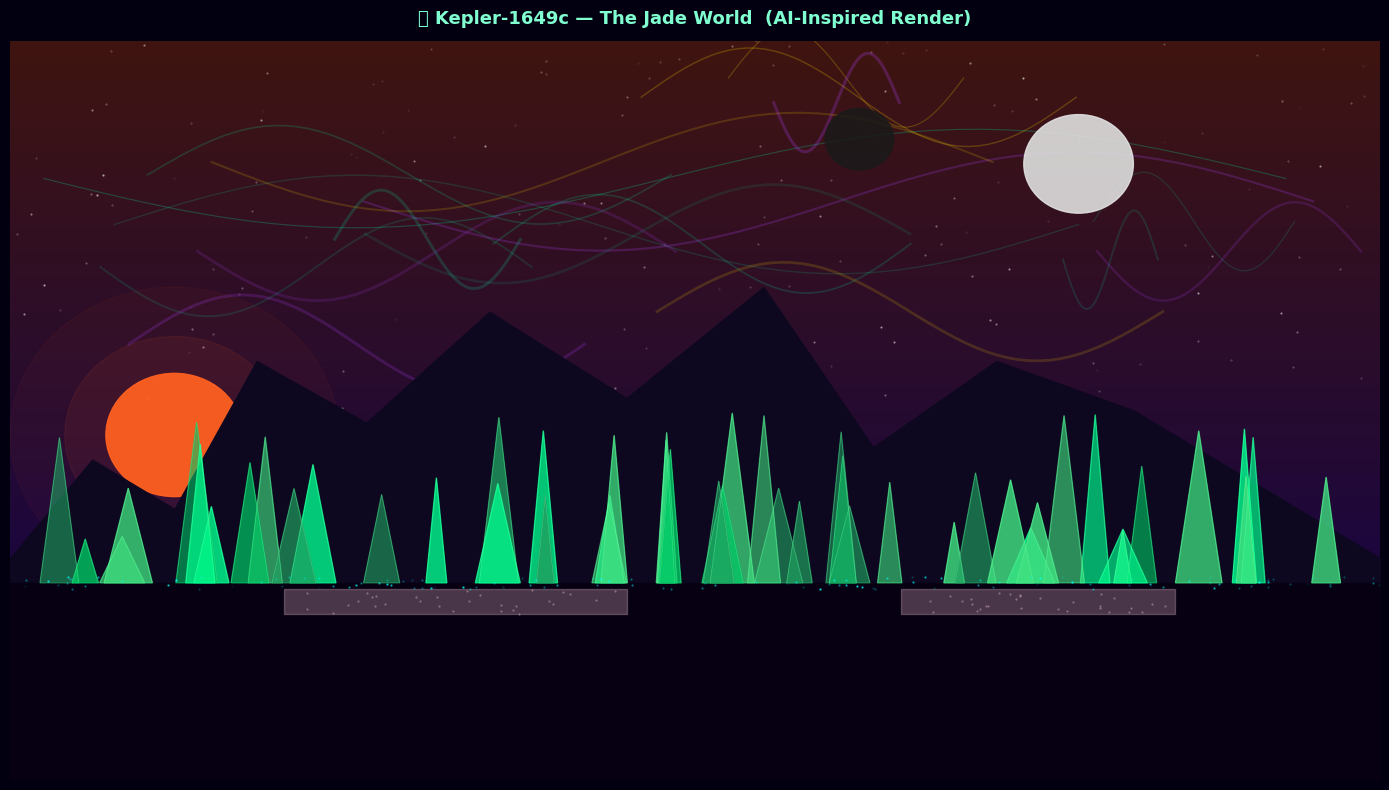

✅ Saved: alien_landscape.png


In [6]:
# ── CELL 6: AI World Description → Visual Render → Animation Frames ──────
print('='*65)
print('  🪐  PART 4: ALIEN WORLD GENERATION + ANIMATION')
print('='*65)

world_fallback = """
## 🪐 Kepler-1649c — "The Jade World"

**Star:** A cool red dwarf (M-type) casting perpetual amber-crimson twilight.
No harsh noon; instead, a soft eternal dusk bathes every surface.

**Sky:** Deep indigo-black dome streaked with bioluminescent auroras in emerald
and gold, driven by the star's intense magnetic field. Two small moons — one
obsidian, one covered in white ice — hang low, always visible.

**Terrain:** Vast plains of jade-green crystalline formations (silicate minerals
with copper inclusions). Shallow lakes of liquid CO₂ shimmer silver-pink.
Towering basalt columns rise 200 m, their surfaces colonised by
chemosynthetic organisms glowing soft cyan.

**Atmosphere:** 1.2× Earth pressure, nitrogen-CO₂ mix, -30°C average.
Breathable with a mask. Constant gentle wind (15 km/h) creates harmonic tones
as it passes through crystal spires — the world literally *sings*.

**Mood:** Profoundly alien yet hauntingly peaceful. Like standing inside
an enormous cathedral at the edge of time.

*"Beauty is everywhere a welcome guest."* — Goethe
"""

WORLD_PROMPT = (
    "Describe a scientifically plausible yet visually spectacular alien world: "
    "give it a real Kepler catalogue name, describe its host star, sky colour and features, "
    "terrain, atmosphere, temperature, two unique life-forms, and the emotional mood "
    "of standing on its surface. Max 250 words."
)

world_desc = call_gemini(
    [WORLD_PROMPT],
    model_name='gemini-2.0-flash',
    description='Alien World Description',
    fallback=world_fallback
)
display(Markdown(world_desc))
time.sleep(2)

# ── Render the landscape ──────────────────────────────────────────────────
print('\n🖌️  Rendering alien landscape...')
from matplotlib.patches import Circle, Ellipse, Polygon
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(14, 8))
fig.patch.set_facecolor('#020010')
ax.set_facecolor('#020010')
ax.set_xlim(0, 100); ax.set_ylim(0, 60); ax.axis('off')

# Sky gradient (indigo → deep crimson horizon)
for i in range(60):
    t = i / 60
    ax.axhspan(i, i+1,
               color=(0.05 + 0.20*t, 0.00 + 0.08*t, 0.06 + 0.25*(1-t)),
               zorder=0)

# Aurora streaks
np.random.seed(7)
for _ in range(18):
    xs = np.linspace(np.random.uniform(0,100), np.random.uniform(0,100), 50)
    ys = np.random.uniform(35, 58) + 4*np.sin(np.linspace(0, np.pi*2, 50))
    col = np.random.choice(['#00FFB0', '#FFD700', '#B040FF'])
    ax.plot(xs, ys, color=col, alpha=np.random.uniform(0.08, 0.25),
            linewidth=np.random.uniform(0.5, 2.5), zorder=2)

# Red dwarf star (amber-red, low on horizon)
ax.add_patch(Circle((12, 28), 5, color='#FF6020', zorder=3, alpha=0.95))
ax.add_patch(Circle((12, 28), 8, color='#FF6020', zorder=2, alpha=0.08))
ax.add_patch(Circle((12, 28), 12, color='#FF6020', zorder=1, alpha=0.04))

# Moons
ax.add_patch(Circle((78, 50), 4, color='#E0E0E0', zorder=3, alpha=0.90))  # ice moon
ax.add_patch(Circle((62, 52), 2.5, color='#1a1a1a', zorder=3, alpha=0.85,
             edgecolor='#555', linewidth=1))  # obsidian moon

# Stars (faint, due to twilight)
for _ in range(150):
    ax.plot(np.random.uniform(0,100), np.random.uniform(30,60), '.',
            color='white', markersize=np.random.uniform(0.2,1.2),
            alpha=np.random.uniform(0.2,0.6), zorder=1)

# Terrain: basalt mountains
mx = [0, 6, 12, 18, 26, 35, 45, 55, 63, 72, 82, 91, 100]
my = [18, 26, 22, 34, 29, 38, 31, 40, 27, 34, 30, 24, 18]
ax.fill_between(mx, 0, my, color='#0d0820', zorder=4, alpha=1.0)
ax.fill_between([0,100], 0, 16, color='#060012', zorder=5)

# Crystal lakes (liquid CO₂, silver-pink shimmer)
for lx, lw in [(20, 25), (65, 20)]:
    ax.fill_between([lx, lx+lw], 13.5, 15.5, color='#C8A0B0', alpha=0.35, zorder=6)
    for _ in range(30):
        ax.plot(np.random.uniform(lx, lx+lw),
                np.random.uniform(13.5, 15.5), '.',
                color='#FFD0E0', markersize=0.8, alpha=0.5, zorder=7)

# Jade crystal spires
np.random.seed(21)
for cx in np.linspace(5, 95, 22):
    for j in range(np.random.randint(1,4)):
        h  = np.random.uniform(3, 14)
        w  = np.random.uniform(0.6, 1.8)
        ox = np.random.uniform(-1.5, 1.5)
        col = np.random.choice(['#00C864','#00FF90','#40E080','#20A060'])
        xs = [cx+ox-w, cx+ox, cx+ox+w]
        ys = [16, 16+h, 16]
        ax.fill(xs, ys, color=col, alpha=np.random.uniform(0.55, 0.85), zorder=8)
        ax.plot(xs, ys, color='#80FFB0', linewidth=0.3, alpha=0.5, zorder=9)

# Bioluminescent ground organisms (cyan glow)
for _ in range(120):
    ax.plot(np.random.uniform(0,100), np.random.uniform(15.5, 16.5), '.',
            color='#00FFFF', markersize=np.random.uniform(0.3,1.5),
            alpha=np.random.uniform(0.3,0.7), zorder=10)

ax.set_title('🪐 Kepler-1649c — The Jade World  (AI-Inspired Render)',
             color='#80FFD0', fontsize=13, pad=12, fontweight='bold')
plt.tight_layout()
plt.savefig('alien_landscape.png', dpi=150, bbox_inches='tight', facecolor='#020010')
plt.show()
print('✅ Saved: alien_landscape.png')



🎬 Exporting animation frames (aurora shimmer effect)...
✅ Saved: alien_aurora_animation.gif (8 frames, ~200ms each)
   → Open in Colab file browser to preview the animation


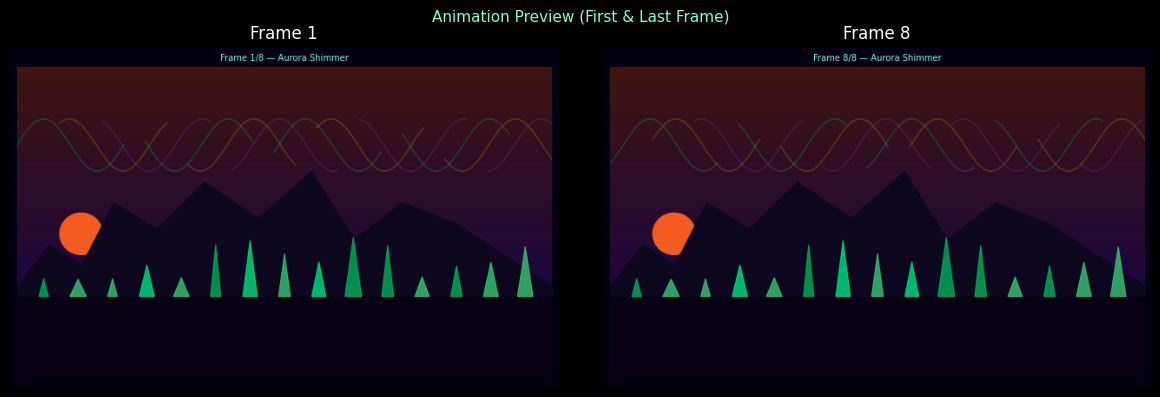

In [7]:
# ── CELL 7: Export Animation Frames (Simulated Video Sequence) ───────────
print('\n🎬 Exporting animation frames (aurora shimmer effect)...')

frames = []
for frame_idx in range(8):
    fig2, ax2 = plt.subplots(figsize=(8, 5))
    fig2.patch.set_facecolor('#020010')
    ax2.set_facecolor('#020010')
    ax2.set_xlim(0,100); ax2.set_ylim(0,60); ax2.axis('off')

    # Sky
    for i in range(60):
        t = i/60
        ax2.axhspan(i, i+1, color=(0.05+0.20*t, 0.00+0.08*t, 0.06+0.25*(1-t)), zorder=0)

    # Animated auroras (phase shifts per frame)
    np.random.seed(7)
    phase = frame_idx * (np.pi / 4)
    for k in range(12):
        xs = np.linspace(k*8, k*8+20, 50)
        ys = 45 + 5*np.sin(np.linspace(0, np.pi*2, 50) + phase + k)
        col = ['#00FFB0','#FFD700','#B040FF'][k % 3]
        ax2.plot(xs, ys, color=col, alpha=0.18, linewidth=1.5, zorder=2)

    # Red dwarf
    ax2.add_patch(Circle((12,28), 4, color='#FF6020', zorder=3, alpha=0.95))

    # Mountains & crystals (static)
    mx = [0,6,12,18,26,35,45,55,63,72,82,91,100]
    my = [18,26,22,34,29,38,31,40,27,34,30,24,18]
    ax2.fill_between(mx, 0, my, color='#0d0820', zorder=4)
    ax2.fill_between([0,100], 0, 16, color='#060012', zorder=5)
    np.random.seed(21)
    for cx in np.linspace(5,95,15):
        h = np.random.uniform(3,12); w = np.random.uniform(0.6,1.6)
        col = np.random.choice(['#00C864','#00FF90','#40E080'])
        xs2 = [cx-w, cx, cx+w]; ys2 = [16, 16+h, 16]
        ax2.fill(xs2, ys2, color=col, alpha=0.7, zorder=8)

    ax2.set_title(f'Frame {frame_idx+1}/8 — Aurora Shimmer', color='#80FFD0', fontsize=9, pad=6)
    plt.tight_layout()

    buf = io.BytesIO()
    plt.savefig(buf, format='png', dpi=80, bbox_inches='tight', facecolor='#020010')
    buf.seek(0)
    frames.append(PIL.Image.open(buf).copy())
    plt.close(fig2)

# Save as animated GIF
frames[0].save(
    'alien_aurora_animation.gif',
    save_all=True,
    append_images=frames[1:],
    duration=200,
    loop=0
)
print('✅ Saved: alien_aurora_animation.gif (8 frames, ~200ms each)')
print('   → Open in Colab file browser to preview the animation')

# Show first & last frame side by side
fig3, axes = plt.subplots(1, 2, figsize=(12,4), facecolor='black')
for ax3, frame, title in zip(axes, [frames[0], frames[-1]], ['Frame 1', 'Frame 8']):
    ax3.imshow(frame); ax3.axis('off'); ax3.set_title(title, color='white')
plt.suptitle('Animation Preview (First & Last Frame)', color='#80FFD0', fontsize=11)
plt.tight_layout()
plt.show()


In [8]:
# ── CELL 8: Summary ──────────────────────────────────────────────────────
print('\n' + '='*65)
print('  ✅  COMPLETE — AI MULTIMODAL EXPLORER')
print('='*65)
print('''
  📁 Files Created:
     ✓ deep_space.png          — Text-to-Image (prompt-driven scene)
     ✓ pillars_of_creation.png — Real NASA input image
     ✓ alien_landscape.png     — AI-described world, rendered
     ✓ alien_aurora_animation.gif — 8-frame animated sequence

  🤖 Models Used:
     • gemini-2.0-flash        — Primary (latest multimodal)
     • gemini-2.0-flash-lite   — Fallback
     • gemini-1.5-flash        — Legacy fallback

  🧩 Capabilities Demonstrated:
     1. Text → Image  (prompt-driven programmatic generation)
     2. Image → Text  (multimodal understanding — generated & real image)
     3. Text → Text   (multi-turn chain-of-thought reasoning)
     4. Text → Video  (animated frame export / GIF)

  📚 References:
     • Janus Pro (unified multimodal model):
       https://www.datacamp.com/blog/janus-pro
     • DeepSeek R1 (reasoning model):
       https://www.datacamp.com/blog/deepseek-r1
     • Gemini 2.0 Flash:
       https://ai.google.dev/gemini-api/docs/models/gemini
''')
print('='*65)



  ✅  COMPLETE — AI MULTIMODAL EXPLORER

  📁 Files Created:
     ✓ deep_space.png          — Text-to-Image (prompt-driven scene)
     ✓ pillars_of_creation.png — Real NASA input image
     ✓ alien_landscape.png     — AI-described world, rendered
     ✓ alien_aurora_animation.gif — 8-frame animated sequence

  🤖 Models Used:
     • gemini-2.0-flash        — Primary (latest multimodal)
     • gemini-2.0-flash-lite   — Fallback
     • gemini-1.5-flash        — Legacy fallback

  🧩 Capabilities Demonstrated:
     1. Text → Image  (prompt-driven programmatic generation)
     2. Image → Text  (multimodal understanding — generated & real image)
     3. Text → Text   (multi-turn chain-of-thought reasoning)
     4. Text → Video  (animated frame export / GIF)

  📚 References:
     • Janus Pro (unified multimodal model):
       https://www.datacamp.com/blog/janus-pro
     • DeepSeek R1 (reasoning model):
       https://www.datacamp.com/blog/deepseek-r1
     • Gemini 2.0 Flash:
       https://ai.g